In [8]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG19
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import os
import warnings
import numpy as np
import pandas as pd
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [9]:

train_dir = "/content/drive/MyDrive/Covid-19_small/train"
val_dir = "/content/drive/MyDrive/Covid-19_small/val"
test_dir = "/content/drive/MyDrive/Covid-19_small/test"

# Data generators
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode= 'nearest',
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    color_mode='rgb',
    batch_size=32,
    class_mode='categorical'
)

val_gen = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    color_mode='rgb',
    batch_size=32,
    class_mode='categorical'
)

test_gen = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    color_mode='rgb',
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)


Found 1610 images belonging to 4 classes.
Found 198 images belonging to 4 classes.
Found 192 images belonging to 4 classes.


In [10]:
# Model
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # freeze base layers

model = models.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(units=256,activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(train_gen.num_classes, activation='softmax')
])

In [11]:
# Compile
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)


In [12]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg19 (Functional)              │ (None, 7, 7, 512)      │    20,024,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,448,196 (100.89 MB)

 Trainable params: 6,423,812 (24.50 MB)

 Non-trainable params: 20,024,384 (76.39 MB)

In [13]:
# Callbacks
checkpoint_path = '/content/drive/MyDrive/covid-19_model-save/VGG19.keras'
callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_accuracy', factor=0.3, patience=2, verbose=1),
    ModelCheckpoint(checkpoint_path, save_best_only=True, monitor='val_accuracy')
]

In [14]:
# Train
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    callbacks=callbacks
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 204s 4s/step - accuracy: 0.3692 - auc: 0.6168 - loss: 1.4364 - val_accuracy: 0.7020 - val_auc: 0.8823 - val_loss: 0.8368 - learning_rate: 1.0000e-04
Epoch 2/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 32s 617ms/step - accuracy: 0.6055 - auc: 0.8482 - loss: 0.9379 - val_accuracy: 0.7576 - val_auc: 0.9221 - val_loss: 0.7055 - learning_rate: 1.0000e-04
Epoch 3/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 33s 641ms/step - accuracy: 0.6462 - auc: 0.8620 - loss: 0.8964 - val_accuracy: 0.7020 - val_auc: 0.9143 - val_loss: 0.7084 - learning_rate: 1.0000e-04
Epoch 4/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 567ms/step - accuracy: 0.6588 - auc: 0.8821 - loss: 0.8278
Epoch 4: ReduceLROnPlateau reducing learning rate to 2.9999999242136255e-05.
51/51 ━━━━━━━━━━━━━━━━━━━━ 31s 603ms/step - accuracy: 0.6592 - auc: 0.8822 - loss: 0.8273 - val_accuracy: 0.7576 - val_auc: 0.9243 - val_loss: 0.6661 - learning_rate: 1.0000e-04
Epoch 5/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 31s 614ms/step - accuracy: 0.6845 - auc: 0

In [15]:
model.save("/content/drive/MyDrive/covid-19_model-save/Vgg19-covid-19.keras")

In [16]:
evaluation = model.evaluate(test_gen)
print(f"Test Loss: {evaluation[0]:.4f}")
print(f"Test Accuracy: {evaluation[1]:.4f}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 56s 11s/step - accuracy: 0.6626 - auc: 0.8773 - loss: 0.8162
Test Loss: 0.6394
Test Accuracy: 0.7500


In [17]:
test_loss, test_acc, test_auc = model.evaluate(test_gen)
print(f"Test Accuracy: {test_acc:.4f}, Test AUC: {test_auc:.4f}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 233ms/step - accuracy: 0.6626 - auc: 0.8773 - loss: 0.8162
Test Accuracy: 0.7500, Test AUC: 0.9292


In [18]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, roc_auc_score
import tensorflow as tf
from itertools import cycle
import json

In [19]:
y_true = test_gen.classes
y_pred_probs = model.predict(test_gen)
y_pred = np.argmax(y_pred_probs, axis=1)
class_labels = list(test_gen.class_indices.keys())

6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 229ms/step


In [20]:
cm = confusion_matrix(y_true, y_pred)
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # normalized

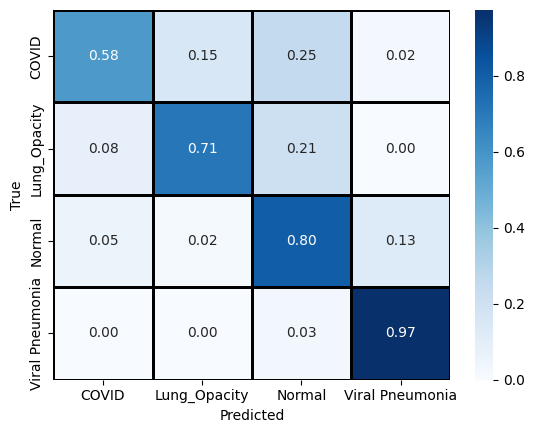

In [34]:
#plt.figure(figsize=(4,3))
sns.heatmap(cmn, annot=True, fmt='.2f', cmap="Blues",
            xticklabels=class_labels, yticklabels=class_labels,
            linecolor='black', linewidth=1)
#plt.title('Normalized Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [22]:
print(classification_report(y_true, y_pred, target_names=class_labels))

                 precision    recall  f1-score   support

          COVID       0.81      0.58      0.67        52
   Lung_Opacity       0.79      0.71      0.75        48
         Normal       0.65      0.80      0.72        55
Viral Pneumonia       0.82      0.97      0.89        37

       accuracy                           0.75       192
      macro avg       0.77      0.76      0.76       192
   weighted avg       0.76      0.75      0.75       192



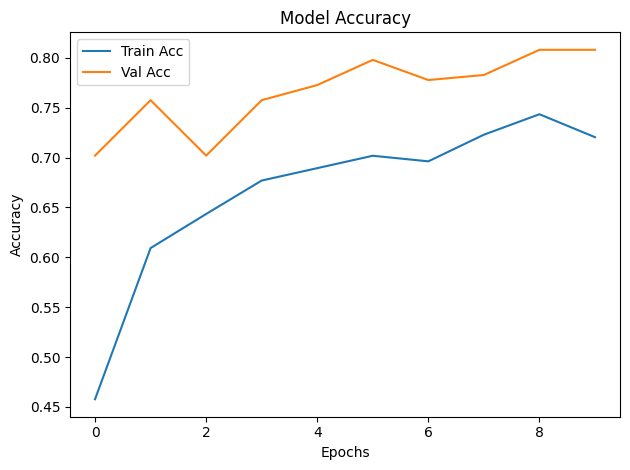

In [36]:
#plt.figure(figsize=(9,4))

#plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

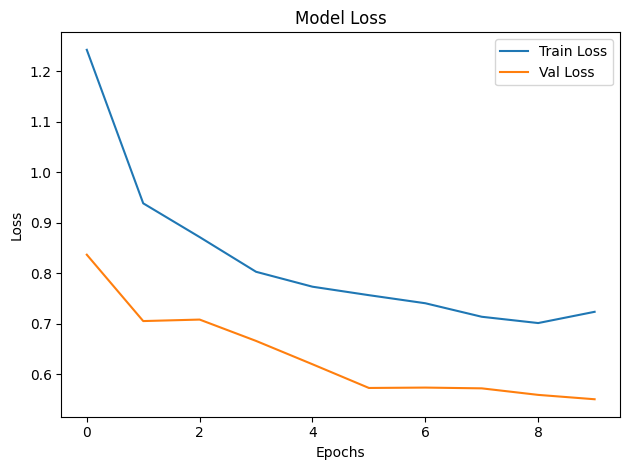

In [37]:
#plt.figure(figsize=(9,4))
#plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

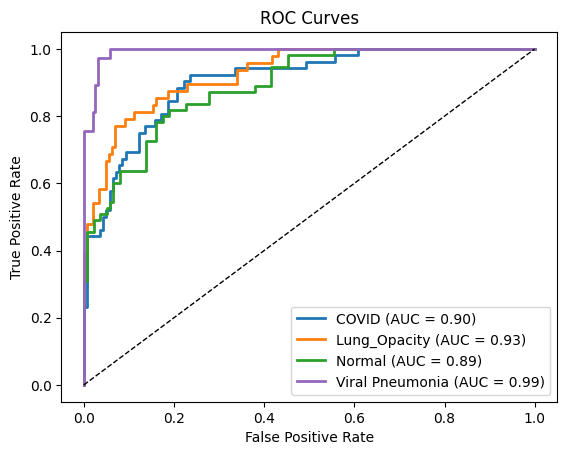

Macro-average AUC: 0.9288


In [41]:
num_classes = len(class_labels)
y_true_cat = tf.keras.utils.to_categorical(y_true, num_classes=num_classes)

fpr, tpr, roc_auc = {}, {}, {}
plt.figure#(figsize=(6,4))
colors = cycle([
    '#1F77B4',  # muted blue
    '#FF7F0E',  # soft orange
    '#2CA02C',  # mellow green
    '#9467BD'   # muted purple
])

for i, color in zip(range(num_classes), colors):
    fpr[i], tpr[i], _ = roc_curve(y_true_cat[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'{class_labels[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0,1],[0,1],'k--', lw=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc='lower right')
plt.show()

macro_auc = roc_auc_score(y_true_cat, y_pred_probs, average='macro')
print(f"Macro-average AUC: {macro_auc:.4f}")

In [26]:
history_file = '/content/drive/MyDrive/covid-19_model-save/Vgg19_training_history.json'
os.makedirs(os.path.dirname(history_file), exist_ok=True)

with open(history_file, 'w') as f:
    json.dump(history.history, f)

print(f"Training history saved to {history_file}")

Training history saved to /content/drive/MyDrive/covid-19_model-save/Vgg19_training_history.json
